# Lab 7: Pitch tracking and modifications

In [109]:
from scipy.io import wavfile
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
import math
import copy
# Make a sound player function that plays array "x" with a sample rate "rate", and labels it with "label"
def sound( x, rate=8000, label=''):
    from IPython.display import display, Audio, HTML
    if label is '':
        display( Audio( x, rate=rate))
    else:
        display( HTML( 
        '<style> table, th, td {border: 0px; }</style> <table><tr><td>' + label + 
        '</td><td>' + Audio( x, rate=rate)._repr_html_()[3:] + '</td></tr></table>'
        ))
def stft( input_sound, dft_size, hop_size, zero_pad, window):

    
    split_sound = np.asarray([input_sound[i : i+dft_size] for i in range(0, len(input_sound) - dft_size, hop_size)]).astype(float)
    split_sound *= window
    out = np.fft.rfft(split_sound)
   
    #Perform DFT on each frame
    
    return out

def istft( stft_output):

    out = np.fft.ifft(stft_output)
    
    x = np.zeros((out.shape))
    # Return reconstructed waveform
    out = np.concatenate(out)
    return out

def analyze_sound(signal, dft_size, hop_size, zero_pad, window, sr, name = ""):
    out = stft(signal, dft_size, hop_size, 0, 1)
    
    f = np.zeros((dft_size // 2, (len(signal) // hop_size)))
    for i in range(0, len(signal) - dft_size, hop_size):
        amps = np.abs(np.fft.fft(signal[i : i+ dft_size]*window, n=dft_size+zero_pad))
        idx = i // hop_size
        for y in range(dft_size // 2):
            f[y][idx] = amps[y]
    plt.figure(figsize=(40, 40))
    ax = plt.subplot(1, 1, 1)
    plt.imshow(f[::-1]**.2, cmap="seismic")
    freq_res = sr / dft_size
    time_res = hop_size / sr
    xticks = ax.get_xticks()[1:-1]
    yticks = ax.get_yticks()[1:-1]
    plt.xticks(xticks, np.round(xticks * time_res , decimals=1))
    plt.yticks(yticks, np.round((yticks * freq_res)[::-1]))
    plt.xlabel("Time (s)")
    plt.ylabel("Freq (Hz)")
    plt.title(name)
    sound(signal, rate=sr, label=name)

## Part 1: Making a pitch tracker

In this section we will design a pitch tracker. We will apply it on this sound file:

[https://drive.google.com/uc?export=download&id=1gB1MlHQJiXRJRYAauWxdJDcRoYs8q0oM ]

We want to find the pitch of the singing over time, as well as if the sound is pitched or not at any point in time. To do so we will design an autocorrelation pitch tracker.
Do the following:
1. Perform an STFT of the sound
2. Using the DFT representation of each frame compute the frame’s autocorrelation
3. Invert each frame’s autocorrelation back to the time domain
4. Find the first peak after the main peak (which will be at the first element)
    - We will only look for pitches between 100 and 300Hz
	- Which means that you only need to look for a peak at a specific range
5. If the peak is more than 70% of the main peak we have a pitched frame
	- Otherwise it is an un-pitched frame
Plot the pitch value over time and see if it correlates with what you are hearing (we also have the correct plot in the lecture slides).


In [4]:
def find_pitch(x, r, thresh = 0.8 ):
    local = x[0]

    for v in range(r[0], r[1]):
        if (x[v] >= local * thresh):
            return 1/v
    return float("NaN")

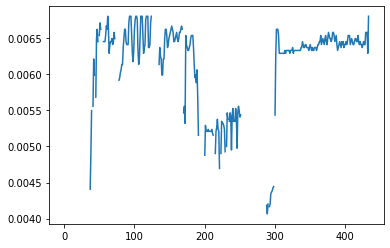

In [52]:
bsr, beauty = wavfile.read("data/beauty.wav")
sound(beauty, bsr)
stft_b = stft(beauty, 1024, 1024, 0, 1)

c = np.fft.irfft(stft_b[:, :] * np.conj(stft_b[:, :]))

#Adjust to freqs 100k - 300k


l = len(c)

pitches = [None] * len(c)

#Convert the location of the autocorrelation peak to a period length in sec, and then to a Hz value

#That will be the pitch value for that frame

for x in range(l):
    c[x, :] = np.concatenate((c[x, :1024 // 2], c[x, 1024 // 2:]))
    v = find_pitch(c[x, :], (bsr // 300, bsr // 100), 0.7)
    pitches[x] = v



plt.plot(pitches)

In [44]:
# YOUR CODE HERE
raise NotImplementedError()

NotImplementedError: 

## Part 2. Changing pitch 

We will now correct the pitch of that last horrible note. We will use the zero crossing method to find where the periods are and then we will shift them appropriately to create a pitch of 274Hz.

1. Get samples 303,000 to 445,000 which is the horrible part.

2. Lowpass filter to facilitate the zero crossing finding

    - Pick an appropriate cutoff frequency that will help
    – Use the ```scipy.signal.filtfilt()``` function which will not time-shift the input
    
3. Find the zero crossing points which should be the starts of each period

4. For each period get the signal from the previous period’s start till this period’s end

5. Window that signal with a Hann window to remove any discontinuities

6. Overlap add each of the above at a rate appropriate for 274Hz

Play the sound, does it sound more in tune? (it better!)

In [57]:
def pitch_routine(x, r, ola_index):
    w = np.hanning(r[1] - r[0])
    return x[r[0]:r[1]] *  w
    

178


"unpitched, bad"


maybe pitched right i cannot tell.


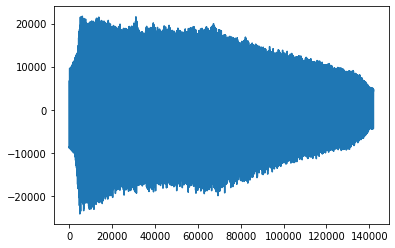

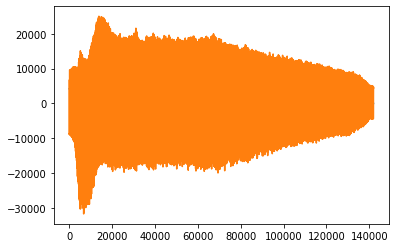

In [117]:
oot = beauty[303000:445000]
orig = copy.deepcopy(beauty[303000:445000])

plt.figure()
plt.plot(oot)
b, a = signal.butter(4, 2/(bsr/2))

oot = signal.filtfilt(b, a, oot)
plt.figure()
plt.plot(oot)


ola_index = bsr // 247
#z_c
p_groups = []

period = []
for i in range(len(oot) - 1):
    #This means we've found a zero crossing
    if(len(period) >= 3):
        p_groups.append(period)
        period = []
    if(oot[i] * oot[i + 1] < 0):
        period.append(i)
print(ola_index)
repitched = []
for p in range(len(p_groups)):      
    repitched.append((pitch_routine(oot, (p_groups[p][0], p_groups[p][2]) , ola_index)))

for x in range(len(p_groups)):

    for y in range(ola_index, len(repitched[x])):
        orig[y] += repitched[x][y - ola_index] * 20
        
plt.plot(orig)
sound(beauty[303000:445000], bsr, "unpitched, bad")
sound(np.concatenate((beauty[:303000], orig)), bsr, "maybe pitched right i cannot tell.")
